<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/autoenc_prep_without_id.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


Importing libraries

In [2]:
import keras
import random
import tensorflow as tf
import keras.backend as K
from matplotlib import pyplot as plt

from tqdm import tqdm
from math import *
from keras.models import Model
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation
from keras.utils.generic_utils import get_custom_objects
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.layers import concatenate
from keras.optimizers import Adam
import gc
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
import pandas as pd
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils import Sequence

In [3]:

np.random.seed(42) # NumPy
random.seed(42) # Python

Loading data

In [6]:

trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv',index_col=[0])

Drop id and isFraud

In [7]:
trn=trn.drop(['isFraud','id'],1)
tst=tst.drop(['id'],1)

Reduce memory useage

In [8]:

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2243.72 MB
Memory usage after optimization is: 554.17 MB
Decreased by 75.3%
Memory usage of dataframe is 1925.14 MB
Memory usage after optimization is: 475.49 MB
Decreased by 75.3%


Concatenate data

In [9]:
X=pd.concat([trn,tst]).reset_index(drop=True)
del([trn,tst])
gc.collect()

0

Divide data into categorical and numerical

In [10]:

cat=[str(i) for i in range(444)]
X[cat]=X[cat].astype('uint8')
no_dum=[i for i in X.columns if i not in cat]
num_shape=len(no_dum)
cat_shape=len(cat)

In [11]:

gc.collect()
def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
def create_model():
    K.clear_session()
    num_inp = Input(shape=(num_shape,))
    cat_inp = Input(shape=(cat_shape,))
    inps = concatenate([num_inp, cat_inp])
    x = Dense(512, activation=custom_gelu)(inps)
    x = Dense(256, activation=custom_gelu)(x)
    x = Dense(512, activation = custom_gelu)(x)
    x = Dropout(.2)(x)
    cat_out = Dense(cat_shape, activation = "linear")(x)
    num_out = Dense(num_shape, activation = "linear")(x)
    model = Model(inputs=[num_inp,cat_inp], outputs=[num_out, cat_out])
    model.compile(
        optimizer=Adam(.05, clipnorm = 1, clipvalue = 1),
        loss=["mse", "mse"]
    )
    return model

Warmup learning rate

In [12]:

class WarmUpLearningRateScheduler(keras.callbacks.Callback):
    """Warmup learning rate scheduler
    """

    def __init__(self, warmup_batches, init_lr, verbose=0):
        """Constructor for warmup learning rate scheduler

        Arguments:
            warmup_batches {int} -- Number of batch for warmup.
            init_lr {float} -- Learning rate after warmup.

        Keyword Arguments:
            verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpLearningRateScheduler, self).__init__()
        self.warmup_batches = warmup_batches
        self.init_lr = init_lr
        self.verbose = verbose
        self.batch_count = 0
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.batch_count = self.batch_count + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        if self.batch_count <= self.warmup_batches:
            lr = self.batch_count*self.init_lr/self.warmup_batches
            K.set_value(self.model.optimizer.lr, lr)
            if self.verbose > 0:
                print('\nBatch %05d: WarmUpLearningRateScheduler setting learning '
                      'rate to %s.' % (self.batch_count + 1, lr))

Data generator for denoising autoencoder

In [13]:

class DAESequence(Sequence):
    def __init__(self,df,no_dum,frac=0.15,dumm=range(911),batch_size=2048):
        self.batch_size=batch_size
        self.frac=0.15
        self.dumm=dumm
        self.df=df
        self.cat_data=df[dumm].values
        self.num_data=df[no_dum].values
        self.no_dumm=no_dum
        self.len_data=df.shape[0]
        self.columns=df.shape[1]
        self.data=df
        self.idx=[]
        
        
        
    def __len__(self):
        return int(ceil(self.len_data/self.batch_size))
    
    
    
    def __getitem__(self,idx):
        self.idx.append(idx)
        last=min((idx+1)*self.batch_size,self.len_data)
        idx=idx*self.batch_size
        size=last-idx
        
        
        inps=[]
        outs=[]
        output_x=self.data.iloc[idx:last]
        
        
        
        
        data=output_x[self.no_dumm].values
        noise_x=data.copy()
        for i in range(len(self.no_dumm)):
            to=np.random.randint(0,size,int(size*self.frac))
            frm=np.random.randint(0,size,int(size*self.frac))
            noise_x[to,i]=noise_x[frm,i]
            
        inps.append(noise_x)
        outs.append(data)
        
        data=output_x[self.dumm].values
        noise_x=data.copy()
        for i in range(len(self.dumm)):
            to=np.random.randint(0,size,int(size*self.frac))
            frm=np.random.randint(0,size,int(size*self.frac))
            noise_x[to,i]=noise_x[frm,i]
        
        
        
        inps.append(noise_x)
        outs.append(data)
        
        
        
        
        
        return inps,outs

Fill nan by mean then by 0

In [14]:

a=X.isna().sum()
a=a[a>0]
cls=list(X)
for col in tqdm(list(a.index)):
  if col in cls:
    X[col]=X[col].fillna(X[col].mean())
a=X.isna().sum()
a=a[a>0]
cls=list(X)
for col in tqdm(list(a.index)):
  if col in cls:
    X[col]=X[col].fillna(0)


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [16]:

model_mse = create_model()
warm_up_lr = WarmUpLearningRateScheduler(400, init_lr=0.0005)
gc.collect()
epochs = 50
batch_size=2048
train_gen=DAESequence(X,no_dum,batch_size=batch_size,dumm=cat)
hist = model_mse.fit_generator(train_gen, steps_per_epoch=len(X)//batch_size, epochs=epochs,
                           verbose=1, workers=-1,
                           use_multiprocessing=True,
                              callbacks=[ warm_up_lr])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
535/535 [==============================] - 23s 43ms/step - loss: 0.2237 - dense_4_loss: 0.1960 - dense_3_loss: 0.0277
Epoch 2/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0842 - dense_4_loss: 0.0711 - dense_3_loss: 0.0131
Epoch 3/50
535/535 [==============================] - 23s 44ms/step - loss: 0.0748 - dense_4_loss: 0.0643 - dense_3_loss: 0.0105
Epoch 4/50
535/535 [==============================] - 23s 44ms/step - loss: 0.0680 - dense_4_loss: 0.0585 - dense_3_loss: 0.0095
Epoch 5/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0643 - dense_4_loss: 0.0553 - dense_3_loss: 0.0090
Epoch 6/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0644 - dense_4_loss: 0.0557 - dense_3_loss: 0.0087
Epoch 7/50
535/535 [==============================] - 23s 43ms/step - loss: 0.0603 - dense_4_loss: 0.0519 - dense_3_loss: 0.0084
Epoch 8/50
535/535 [=

In [17]:
mod=Model(inputs=model_mse.inputs,outputs=model_mse.layers[4].output)
mod.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 53)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 444)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 497)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          254976      concatenate[0][0]     

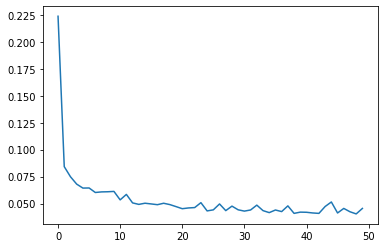

In [18]:

plt.plot(hist.history['loss'])

In [19]:
pre=mod.predict([X[no_dum],X[cat]])
pre.shape

(1097231, 256)

In [20]:
pd.DataFrame(pre).to_csv('/content/gdrive/My Drive/fraud/without_id.csv')